In [2]:
!rosbag info ocupancy.bag

path:        ocupancy.bag
version:     2.0
duration:    3.9s
start:       Oct 30 2023 14:41:09.58 (1698666069.58)
end:         Oct 30 2023 14:41:13.49 (1698666073.49)
size:        15.3 MB
messages:    40
compression: none [20/20 chunks]
types:       nav_msgs/OccupancyGrid [3381f2d731d4076ec5c71b0759edbe4e]
topics:      /occupancy_grid_map/grid_map   40 msgs    : nav_msgs/OccupancyGrid


In [3]:
import sys
for s in sys.path:
    print(s)

/root/projects/notebooks

/opt/ros/noetic/lib/python3/dist-packages
/usr/lib/python38.zip
/usr/lib/python3.8
/usr/lib/python3.8/lib-dynload
/root/.local/lib/python3.8/site-packages
/usr/local/lib/python3.8/dist-packages
/usr/lib/python3/dist-packages


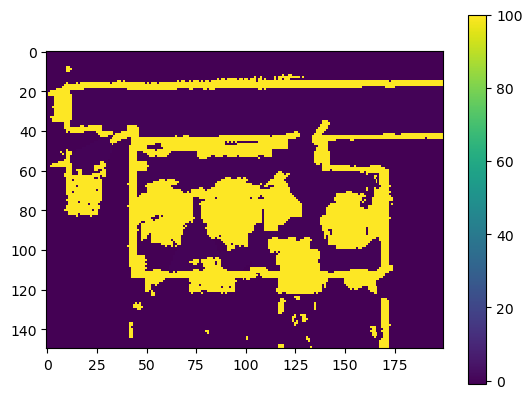

resolution 0.10000000149011612


In [4]:
import rosbag
import numpy as np
from nav_msgs.msg import OccupancyGrid
from matplotlib import  pyplot as plt
bag = rosbag.Bag('ocupancy.bag')
for topic, msg, t in bag.read_messages():
    msg: OccupancyGrid = msg
    occ = np.array(msg.data)
    occ = occ.reshape((msg.info.height, msg.info.width))
    break
plt.imshow(occ[150: 300, 50:250])
plt.colorbar()
plt.show()
# plt.colorbar()
res = msg.info.resolution
print(f'resolution {res}')

In [5]:
husky_base =np.array([0.6, 1])
print(np.round(husky_base/res))
print(0.9/res)

[ 6. 10.]
8.999999865889551


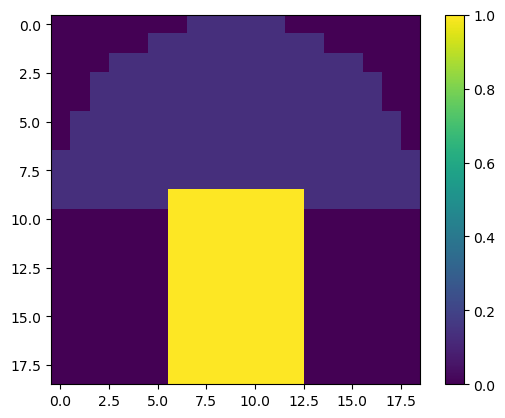

In [6]:
from PIL import  Image

i = Image.open('realrobot_footprint.png')
np_img = np.asarray(i)
np_img = np.int32(np.linalg.norm(np_img[:,:, :3], axis=-1))
np_img = np_img / np_img.max()
np_img = 1 - np_img
plt.imshow(np_img)
plt.colorbar()
plt.show()

torch.Size([19, 19])


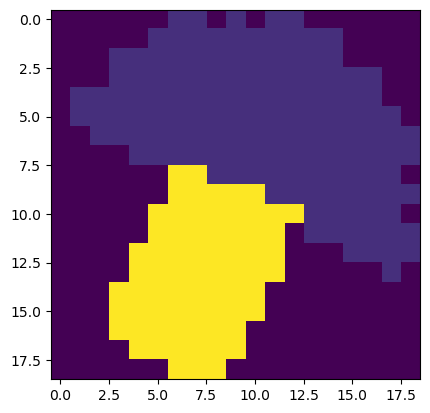

In [7]:
from torchvision.transforms.functional import  rotate
from torchvision.transforms import InterpolationMode
import torch
print(torch.tensor(np_img).shape)

r = [rotate(img = torch.tensor(np_img).unsqueeze(0), angle=angl, fill =np_img.min()  ).squeeze(0) for angl in np.linspace(0, 360, 4*4)][:-1]
plt.imshow(r[-1])
plt.show()

/tmp/ipykernel_203581/2791990061.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight_tensor = torch.tensor( r[0], dtype= torch.float32)


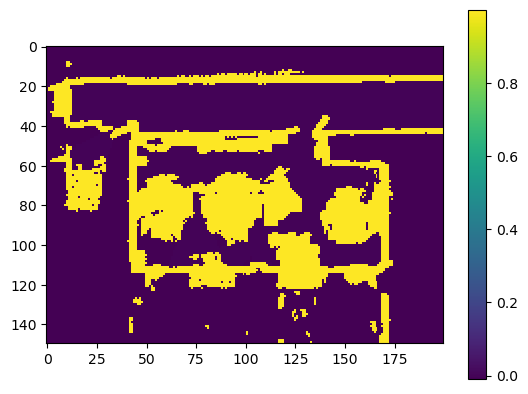

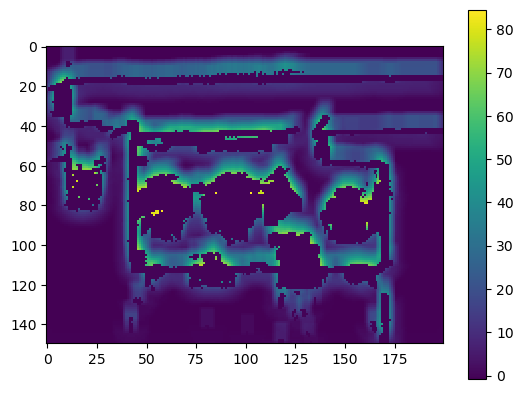

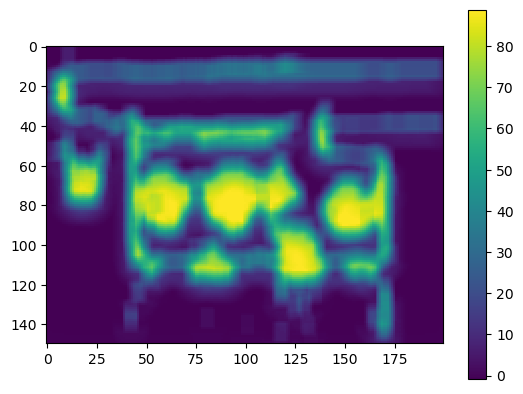

In [15]:
map_tensor = torch.tensor(occ[150: 300, 50:250], dtype=torch.float32)
map_tensor /= map_tensor.max()
weight_tensor = torch.tensor( r[0], dtype= torch.float32)
weight_tensor /= weight_tensor.max()
plt.imshow(map_tensor)
plt.colorbar()
plt.show()
out = torch.nn.functional.conv2d(map_tensor.unsqueeze(axis= 0), weight_tensor.unsqueeze(axis= 0).unsqueeze(axis= 0), padding='same')
# out /= out.max()
plt.imshow(out[0] * (map_tensor<0.01))
plt.colorbar()
plt.show()
plt.imshow(out[0])
plt.colorbar()
plt.show()

In [9]:
len(weight_tensor.shape)

2

In [10]:
print(weight_tensor.max())
print(map_tensor.max())
print(out[0].max())

tensor(1.)
tensor(1.)
tensor(88.8640)


/tmp/ipykernel_203581/3993007532.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight_tensor = torch.tensor( r[4], dtype= torch.float32)


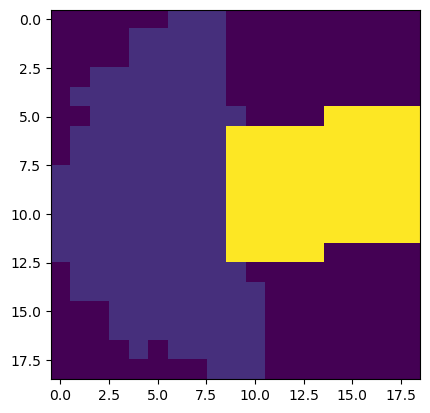

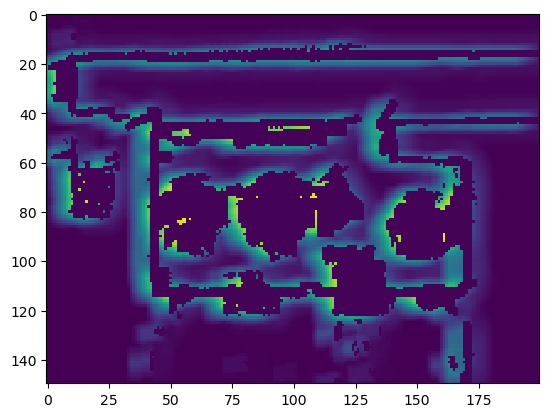

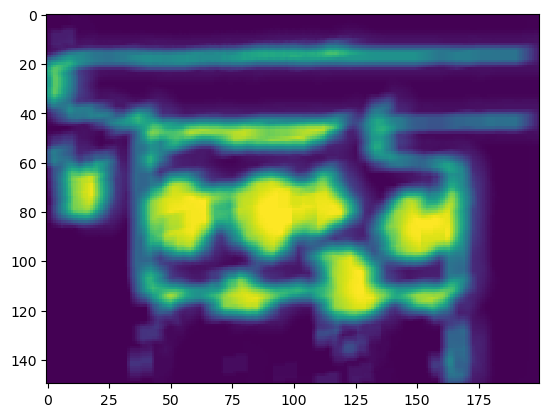

In [11]:
map_tensor = torch.tensor(occ[150: 300, 50:250], dtype=torch.float32)
map_tensor /= map_tensor.max()
weight_tensor = torch.tensor( r[4], dtype= torch.float32)
weight_tensor /= weight_tensor.max()
out = torch.nn.functional.conv2d(map_tensor.unsqueeze(axis= 0), weight_tensor.unsqueeze(axis= 0).unsqueeze(axis= 0), padding='same')
out /= out.max()
plt.imshow(r[4])
plt.show()
plt.imshow(out[0] * (map_tensor<0.01))
plt.show()
plt.imshow(out[0])
plt.show()

/tmp/ipykernel_203581/3992130308.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight_tensor = torch.tensor( r[0], dtype= torch.float32)


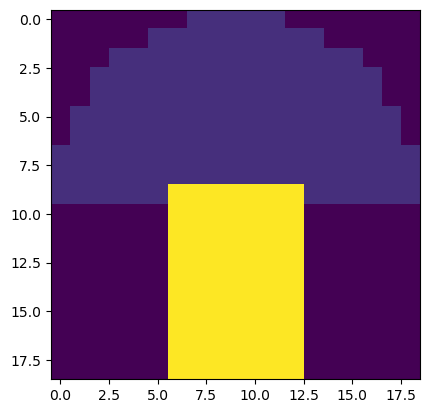

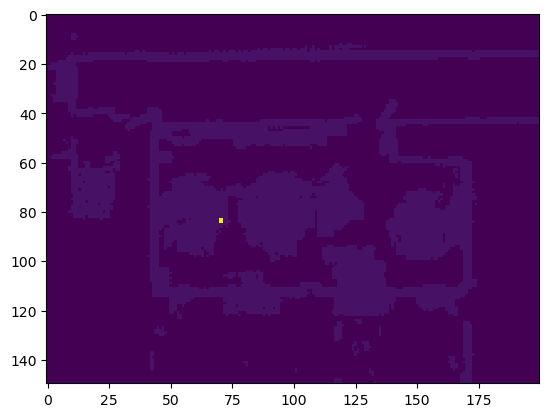

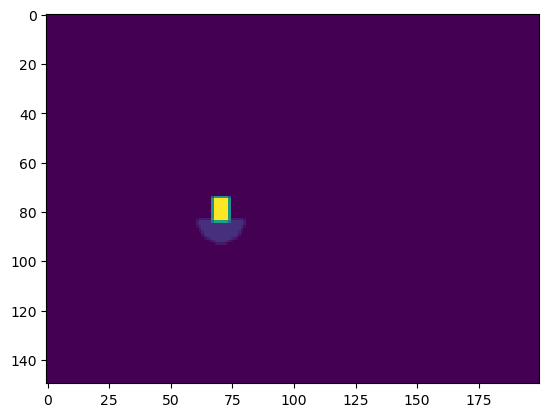

In [19]:
target_map = np.zeros_like(map_tensor)
target_map[83:85,70:72] = 20
target_map_tensor = torch.tensor(target_map)
weight_tensor = torch.tensor( r[0], dtype= torch.float32)
out = torch.nn.functional.conv2d(target_map_tensor.unsqueeze(axis= 0), weight_tensor.unsqueeze(axis= 0).unsqueeze(axis= 0), padding='same')
plt.imshow(weight_tensor)
plt.show()
plt.imshow(target_map_tensor + map_tensor)
plt.show()
plt.imshow(out[0])
plt.show()

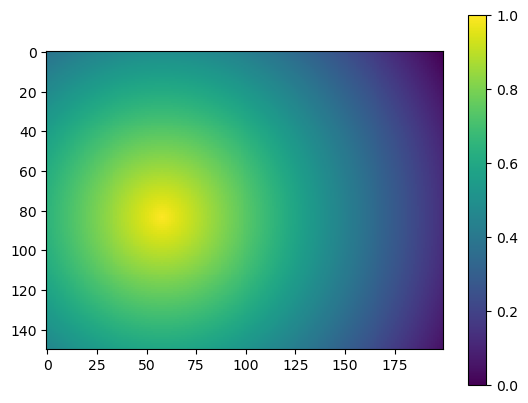

In [13]:
from typing import Tuple
import math
def make_dist_map(target : Tuple[int, int] , size : Tuple[int, int]):
    img = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            img[i, j] = np.linalg.norm([target[0] - i, target[1] - j])
    return img

def norm_hmap(hmap : np.ndarray):
    hmap /= hmap.max()
    return 1 - hmap

dist_map = make_dist_map((83, 58), map_tensor.shape)
dist_map = norm_hmap(dist_map)
plt.imshow(dist_map)
plt.colorbar()
plt.show()

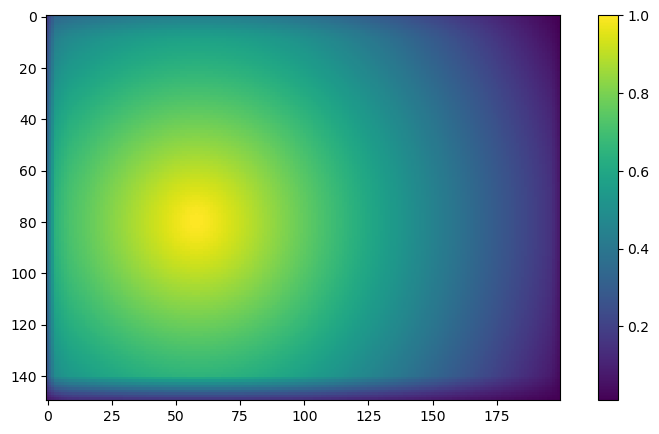

In [14]:
dist_map_tensor = torch.tensor(dist_map, dtype=torch.float32)
out = torch.nn.functional.conv2d(dist_map_tensor.unsqueeze(axis= 0), weight_tensor.unsqueeze(axis= 0).unsqueeze(axis= 0), padding='same')
plt.figure(figsize=(10,5))
plt.imshow(out[0]/out.max())
plt.colorbar()
plt.show()